In [1]:
!pip install networkx

In [22]:
# Run if working locally
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [23]:
import sqlite3
from sqlite3 import Error
import pickle
import os, sys
import config

config.root_path = os.path.abspath(os.path.join(os.getcwd(), ".."))
sys.path.insert(0, config.root_path)

from src.dataset.dataset import RawData
from src.dataset.wikisection_preprocessing import (
    tokenize,
    clean_sentence,
    preprocess_text_segmentation,
    format_data_for_db_insertion,
)

from src.dataset.utils import truncate_by_token, flatten, dedupe_list, truncate_string
from src.bertkeywords.src.similarities import Embedding, Similarities
from src.bertkeywords.src.keywords import Keywords, Keyword
from db.dbv2 import Table, AugmentedTable, TrainTestTable
import pprint


from utils.metrics import windowdiff, pk
import networkx as nx

ImportError: cannot import name 'Keyword' from 'src.bertkeywords.src.keywords' (/Users/mac/Documents/PhD/HumanMachineLab/CoherenceGraph/src/bertkeywords/src/keywords.py)

In [14]:
dataset_type = "city"
table = Table(dataset_type)

num_sentences = 10

all_segments = table.get_all_segments()

segments = [[y[1] for y in x] for x in all_segments]
segments_labels = [
    [1 if i == 0 else 0 for i, y in enumerate(x)] for x in all_segments
]

flattened_segments = flatten(segments)
flattened_labels = flatten(segments_labels)

segments_to_test = flattened_segments[:num_sentences]
labels_to_test = flattened_labels[:num_sentences]

Using dataset: wikisection_city


In [6]:
import networkx as nx
import matplotlib.pyplot as plt

class CoherenceNode():
    def __init__(self, id, word, vector):
        self.id = id
        self.word = word
        self.vector = vector
        # self.distance = distance
        # self.level = level
    
    def __repr__(self):
        return f'Node({self.id}, \'{self.word}\', {self.vector})'
        
    def __str__(self):
        return f'Node(\'{self.word}\')'

class CoherenceGraph(nx.Graph):
    def __init__(self):
        nx.Graph.__init__(self)

    # overriden function to add more functionality to the traditional add_edge function
    def add_edge(self, *args, **kwargs):
        super().add_edge(*args, **kwargs)

    # get a node based on an id
    def get_node_by_id(self, id: str):
        for n, nbrs in G.adj.items():
            if n.id == id:
                return (n, nbrs)
        return None

    # get a node based on a word
    def get_node(self, word: str):
        for n, nbrs in G.adj.items():
            if n.word == word:
                return (n, nbrs)
        return None

    # remove all nodes that don't have any edges
    def prune_isolated_nodes(self):
        isolated_nodes = list(nx.isolates(self))
        self.remove_nodes_from(list(nx.isolates(self)))
        return isolated_nodes

    # remove all nodes beyond the max_depth
    def prune_max_depth(self, max_depth: int, current_node: CoherenceNode):
        pruned_nodes = []
        for n, nbrs in G.adj.items():
            try:
                if nx.shortest_path_length(G, source=n, target=current_node) >= max_depth:
                    pruned_nodes.append(n)
            except:
                # no shortest path could be found - node is isolated
                pass

        self.remove_nodes_from(list(pruned_nodes))
        return pruned_nodes

    # we want to get all the nodes that have some pathway to the current node
    # so we can gather all the cohesive words and make a word compilation vector.
    def get_all_paths_to_node(self, current_node: CoherenceNode):
        paths = []
        for n in self.nodes():
            for path in nx.all_simple_paths(G, source=current_node, target=n):
                paths.append(path)
        return paths


In [7]:
G = CoherenceGraph()

### Keywords

In [17]:
model_string="bert-base-uncased"

similarities_lib = Similarities(model_string)
keywords_lib = Keywords(similarities_lib.model, similarities_lib.tokenizer)
embedding_lib = Embedding(
    similarities_lib.model, similarities_lib.tokenizer
)
max_words_per_step = 4
keyword_diversity = 0.3

No sentence-transformers model found with name /Users/mac/.cache/torch/sentence_transformers/bert-base-uncased. Creating a new one with MEAN pooling.


In [18]:
embedding_technique = (keywords_lib.get_batch_keywords_with_kb_embeddings)

In [19]:
# get all the keywords per sentence and truncate at max number of words
batch_keywords = [
    x[:max_words_per_step]
    for x in embedding_technique(
        segments_to_test,
        diversity=keyword_diversity,
        diverse_keywords=True,
        similar_keywords=True,
    )
]

In [20]:
batch_keywords

[[('sebastiae',
   0.5166,
   array([ 3.01045537e-01, -2.09570765e-01, -1.77952722e-01, -9.64432489e-03,
           2.99028426e-01, -2.60903090e-01,  3.92596096e-01,  2.35923026e-02,
          -4.11095649e-01, -2.92805463e-01,  1.79942831e-01, -8.86194706e-02,
          -8.77290126e-03,  3.67987037e-01, -2.37863567e-02,  4.72122878e-01,
          -4.34971899e-01, -5.28461374e-02,  3.81146878e-01, -2.67716497e-02,
           1.43610999e-01,  4.60078008e-02, -1.22421347e-01,  1.33494824e-01,
           1.43467501e-01,  2.78051551e-02, -4.62408215e-01, -9.67864767e-02,
          -4.37806278e-01, -7.99153447e-02,  1.59430265e-01, -4.90083285e-02,
          -4.07324463e-01,  2.58301616e-01, -3.12206924e-01,  3.70026045e-02,
           1.64072171e-01, -9.72171202e-02, -8.76911506e-02, -3.12457919e-01,
          -1.49611503e-01, -4.70615059e-01,  2.62594223e-01, -2.75971055e-01,
          -3.94835211e-02, -3.78338248e-02,  1.03248008e-01, -2.78403521e-01,
          -2.59610415e-01, -4.3050259

---

In [252]:
# (id, word_text, vector_representation)

segments = [
    [(0, "hello", 5), (1, "world", 6), (2, "earth", 7)],
    [(3, "school", 3), (4, "work", 5)],
    [(5, "assignments", 6), (6, "deadline", 4), (7, "lazy", 2), (8, "midterms", 5)],
    [(9, "gym", 4.5), (10, "math", 6), (11, "science", 6.5), (12, "world", 2)],
]

In [253]:
# simulation

temp_prev_graph = nx.Graph()
for segment in segments:
    # create a previous graph to hold all the words from the previous sentence
    # such that we can only compare the current words with the previous sentence
    prev_graph = temp_prev_graph
    temp_prev_graph = nx.Graph()
    for word in segment:
        # create a temp graph to hold the edges, which we'll use to compose a new graph
        # after the iteration, since the graph size can't fluctuate as we iterate through
        temp_graph = nx.Graph()
        node = CoherenceNode(word[0], word[1], word[2])
        for n in prev_graph.nodes():
            if n.vector*node.vector >= 20:
                temp_graph.add_edge(node, n, weight=n.vector*node.vector)
        G = nx.compose(G,temp_graph)
        temp_prev_graph.add_node(node)
        # add the node. If it was already added, it won't be added again
        G.add_node(node)

In [254]:
# G.prune_max_depth(1, G.get_node_by_id(0)[0])

In [255]:
for path in nx.all_simple_paths(G, source=G.get_node_by_id(1)[0], target=G.get_node_by_id(4)[0]):
    print(path)

[Node(1, 'world', 6), Node(4, 'work', 5)]


In [256]:
G.get_all_paths_to_node(G.get_node_by_id(4)[0])

[[Node(4, 'work', 5), Node(0, 'hello', 5)],
 [Node(4, 'work', 5), Node(1, 'world', 6)],
 [Node(4, 'work', 5), Node(2, 'earth', 7)],
 [Node(4, 'work', 5), Node(2, 'earth', 7), Node(3, 'school', 3)],
 [Node(4, 'work', 5), Node(5, 'assignments', 6)],
 [Node(4, 'work', 5),
  Node(6, 'deadline', 4),
  Node(10, 'math', 6),
  Node(5, 'assignments', 6)],
 [Node(4, 'work', 5),
  Node(6, 'deadline', 4),
  Node(10, 'math', 6),
  Node(8, 'midterms', 5),
  Node(9, 'gym', 4.5),
  Node(5, 'assignments', 6)],
 [Node(4, 'work', 5),
  Node(6, 'deadline', 4),
  Node(10, 'math', 6),
  Node(8, 'midterms', 5),
  Node(11, 'science', 6.5),
  Node(5, 'assignments', 6)],
 [Node(4, 'work', 5),
  Node(6, 'deadline', 4),
  Node(11, 'science', 6.5),
  Node(5, 'assignments', 6)],
 [Node(4, 'work', 5),
  Node(6, 'deadline', 4),
  Node(11, 'science', 6.5),
  Node(8, 'midterms', 5),
  Node(9, 'gym', 4.5),
  Node(5, 'assignments', 6)],
 [Node(4, 'work', 5),
  Node(6, 'deadline', 4),
  Node(11, 'science', 6.5),
  Node(8,

In [257]:
repr(G.get_node_by_id(0))

"(Node(0, 'hello', 5), AtlasView({Node(4, 'work', 5): {'weight': 25}}))"

In [258]:
G.nodes

NodeView((Node(0, 'hello', 5), Node(1, 'world', 6), Node(2, 'earth', 7), Node(3, 'school', 3), Node(4, 'work', 5), Node(5, 'assignments', 6), Node(6, 'deadline', 4), Node(7, 'lazy', 2), Node(8, 'midterms', 5), Node(9, 'gym', 4.5), Node(10, 'math', 6), Node(11, 'science', 6.5), Node(12, 'world', 2)))

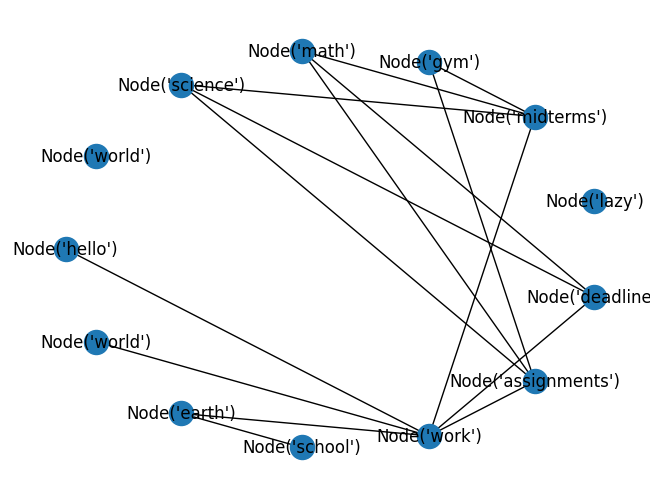

In [262]:
nx.draw_shell(G, with_labels = True)

In [123]:
node, neighbors = G.get_node("hello")

repr(node)

"Node('hello', 5)"

In [116]:
for n in neighbors:
    print(repr(n))

Node('earth', 7)
Node('science', 6.5)


In [117]:
for n in G.edges:
    print(n[0].word, n[1].word)

hello earth
hello science
world earth
world assignments
world math
world science
earth work
earth assignments
earth midterms
earth gym
earth math
earth science
work science
assignments math
assignments science
midterms science
math science


In [118]:
for n, nbrs in G.adj.items():
    for nbr, eattr in nbrs.items():
        print(eattr)
        wt = eattr['weight']
        if wt > 0.5: print(f"({n.word}, {nbr.word}, {wt})")

{'weight': 35}
(hello, earth, 35)
{'weight': 32.5}
(hello, science, 32.5)
{'weight': 42}
(world, earth, 42)
{'weight': 36}
(world, assignments, 36)
{'weight': 36}
(world, math, 36)
{'weight': 39.0}
(world, science, 39.0)
{'weight': 35}
(earth, hello, 35)
{'weight': 42}
(earth, world, 42)
{'weight': 35}
(earth, work, 35)
{'weight': 42}
(earth, assignments, 42)
{'weight': 35}
(earth, midterms, 35)
{'weight': 31.5}
(earth, gym, 31.5)
{'weight': 42}
(earth, math, 42)
{'weight': 45.5}
(earth, science, 45.5)
{'weight': 35}
(work, earth, 35)
{'weight': 32.5}
(work, science, 32.5)
{'weight': 36}
(assignments, world, 36)
{'weight': 42}
(assignments, earth, 42)
{'weight': 36}
(assignments, math, 36)
{'weight': 39.0}
(assignments, science, 39.0)
{'weight': 35}
(midterms, earth, 35)
{'weight': 32.5}
(midterms, science, 32.5)
{'weight': 31.5}
(gym, earth, 31.5)
{'weight': 36}
(math, world, 36)
{'weight': 42}
(math, earth, 42)
{'weight': 36}
(math, assignments, 36)
{'weight': 39.0}
(math, science, 3